In [3]:
import pandas as pd
import numpy as np
import math

df_vwc = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_vwc_.npy', allow_pickle=True)
df_stemp = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_stemp_.npy', allow_pickle=True)
df_T = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_T.npy', allow_pickle=True)
df_RH = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_RH.npy', allow_pickle=True)
df_DP = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_DP.npy', allow_pickle=True)
df_Rain = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_Rain.npy', allow_pickle=True)
df_WS = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WS.npy', allow_pickle=True)
df_WD = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WD.npy', allow_pickle=True)
df_S = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_S.npy', allow_pickle=True)

list_ = [df_vwc, df_Rain, df_stemp, df_T, df_RH, df_DP, df_WS, df_WD, df_S]

# IMF = np.empty((10, 10, 10))
IMFs = [[],[],[],[],[],[],[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(IMFs)):
  for i in list_:
    IMFs[k].append(i[k])


# df_vwc = pd.DataFrame(df_vwc).T
# df_vwc.columns = ['IMF1','IMF2','IMF3','IMF4','IMF5','IMF6','IMF7','IMF8','IMF9','IMF10','IMF11',
#               'IMF12','IMF13','IMF14', 'IMF15']

# df_stemp = pd.DataFrame(df_stemp).T
# df_stemp.columns = ['IMF1','IMF2','IMF3','IMF4','IMF5','IMF6','IMF7','IMF8','IMF9','IMF10','IMF11',
#               'IMF12','IMF13']

In [ ]:
pd.DataFrame(df_vwc).T.describe()

In [ ]:
trial = []
for i in range(len(pd.DataFrame(df_vwc).T)):
  trial.append(np.sum(pd.DataFrame(df_vwc)[i][8]))

In [4]:
##LSTM
import pandas as pd
import numpy as np
import math

import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count 
from joblib import Parallel 
from joblib import delayed 
from datetime import datetime

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu

# from warnings import catch_warnings 
# from warnings import filterwarnings

In [5]:
####################################################################################################
def nmse(y_true, y_pred):
    """
    Calculate the normalized mean squared error (NMSE) between y_true and y_pred.
    """
    return np.mean(np.square(y_pred - y_true)) / np.var(y_true)
####################################################################################################
def smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between y_true and y_pred.
    """
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
####################################################################################################
def smase(y_true, y_pred, y_naive):
    """
    Calculate the Symmetric Mean Absolute Scaled Error (sMASE) between y_true and y_pred, relative 
    to a symmetric naive forecast y_naive.
    """
    # Calculate the symmetric naive forecast
    y_sym_naive = (y_naive.shift(1) + y_naive.shift(-1)) / 2.0
    
    # Calculate the MAPE of the forecast relative to the symmetric naive forecast
    mape_forecast = np.mean(np.abs(y_pred - y_sym_naive) / np.abs(y_true - y_sym_naive))
    
    # Calculate the MAPE of the historical data relative to the same symmetric naive forecast
    mape_historical = np.mean(np.abs(y_true - y_sym_naive.shift(1)) / np.abs(y_true - y_sym_naive))
    
    return mape_forecast / mape_historical
####################################################################################################
def nse(y_true, y_pred):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) between y_true and y_pred.
    """
    mse = mean_squared_error(y_true, y_pred)
    rss = mse * len(y_true)
    tss = mean_absolute_error(y_true, np.mean(y_true)) ** 2 * len(y_true)
    return 1 - (rss / tss)
#####################################################################################################
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Register the custom metric function with Keras
with custom_object_scope({'r2_keras': r2_keras}):
    get_custom_objects().update({'r2_keras': r2_keras})

In [ ]:
index = pd.DataFrame(dataset.index)
var = pd.DataFrame(MinMaxScaler().fit_transform(data))
df = pd.concat([index, var], axis = 1)
df = df.set_index('Date Time')
df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']
df_s = df[df.columns[0:2].values]
#split into train and test
train, test = split_dataset(df_s.values)
train_x, train_y = to_supervised(train, n_input=200)
train_x.shape


In [7]:


##Encoder/Decoder LSTM with Multivariate Input

#Splitting datasets into train/test set

def split_dataset(data):
  # split into standard weeks
  #train, test = data[1:-6046], data[-6048:]
  train, test = data[:-5817], data[-5817:-57]
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/9))
  test = np.array(np.split( test , len(test )/9))
  return train, test

def rmse_(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def nmse(actual, predicted):
    return mean_squared_error(actual, predicted) / np.var(actual)

def smape(actual, predicted):
    return 100 / len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

def nse(actual, predicted):
    return 1 - np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2)

def r2(y_true, y_pred):
    SS_res =  np.sum(K.square(y_true - y_pred))
    SS_tot =  np.sum(K.square(y_true - np.mean(y_true)))
    return 1 - SS_res/(SS_tot + np.finfo(float).eps) 

def evaluate_forecasts(actual, predicted):
    rmse_scores = [rmse_(actual[:, i],   predicted[:, i])      for i in  range(actual.shape[1])]
    nmse_scores = [nmse(actual[:, i],    predicted[:, i])      for i in  range(actual.shape[1])]
    smape_scores = [smape(actual[:, i],  predicted[:, i])      for i in  range(actual.shape[1])]
    nse_scores = [nse(actual[:, i],      predicted[:, i])      for i in  range(actual.shape[1])]
    r2_scores = [r2(actual[:,i],   predicted[:, i])      for i in  range(actual.shape[1])]
    overall_rmse = rmse_(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_nmse = nmse(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_smape = smape(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_nse = nse(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_r2 = r2(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores

#####################################################################################################
#summarize scores
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=9):
  #flattern data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for i in range(len(data)):
    #define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    #ensure there is enough data
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return np.array(X), np.array(y)
 
# #train the model LSTM-ED
def build_model(train, config, verbose):
  # Unpack config
  n_input, n_nodes, n_epochs, n_batch = config
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # Parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  
  #define model
  
  model = Sequential()
  model.add(LSTM(n_nodes, activation ='tanh', input_shape = (n_timesteps, n_features)))#
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(n_nodes, activation ='tanh',  return_sequences = True))#
  #model.add(BatchNormalization())
  #model.add(Dropout(0.2))
  # model.add(LSTM(25, activation ='tanh', return_sequences = True))
  # model.add(LSTM(5, activation ='tanh', return_sequences = True, dropout=0.3))
  model.add(TimeDistributed(Dense(n_nodes/2,  activation ='tanh' )))#, 
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mse', optimizer='adam',  metrics= ['MeanAbsoluteError', 'MeanSquaredError', 'mean_absolute_percentage_error', 'r2_keras'])
  # fit network
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose= verbose)
  plt.plot(model.history.history['loss'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['loss'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_error'])
  plt.plot(model.history.history['mean_squared_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_error', 'mean_squared_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_percentage_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_percentage_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['r2_keras'])
  #plt.plot(model.history.history[])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['r2_score'], loc='upper right')
  plt.show()
  return model

  # # define model
  # model = Sequential()
  # model.add(LSTM(n_nodes, input_shape=(n_timesteps, n_features), kernel_initializer=GlorotUniform()))
  # model.add(BatchNormalization())
  # model.add(RepeatVector(n_outputs))
  # model.add(LSTM(n_nodes, activation=relu, return_sequences=True, kernel_initializer=GlorotUniform()))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.2))
  # model.add(TimeDistributed(Dense(n_nodes, activation=relu, kernel_initializer=GlorotUniform())))
  # model.add(Dropout(0.2))
  # model.add(TimeDistributed(Dense(1, kernel_initializer=GlorotUniform())))
  # model.compile(loss='mse', optimizer='adam',  metrics= ['MeanAbsoluteError', 'MeanSquaredError'])

  # # fit network
  # model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=verbose)
  # plt.plot(model.history.history['loss'])
  # return model

#forecast
def forecast(model, history, config):
  # unpack config
  n_input, _, _, _ = config
  #flattern data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  #retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  #forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat
  return yhat

#evaluate a single model
def evaluate_model(train, test, cfg, verbose):
  #fit model
  model= build_model(train, cfg, verbose)
  #test = X_scaler.transform(test)
  # history is a list of n_input data
  history = [x for x in train]
  #walk_forward validation over each week
  predictions = list()
  for i in range(len(test)):
    #predict the week
    yhat_sequence = forecast(model, history, cfg)[0]
    #store the predictions
    predictions.append(yhat_sequence)
    #get real observation an add to history for predicting the next week
    history.append(test[i, :])
  #evaluate predictions hours for each n_input
  predictions = np.array(predictions)
  #overall_rmse,overall_nmse, overall_smape, overall_nse, rmse_scores, nmse_scores, smape_scores, nse_scores
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores = evaluate_forecasts(test[:, :, 0], predictions)
  return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions, model

#Repeat evaluate
def repeat_evaluate(train, test, config, verbose, n_repeats=10):
  # Convert config to a key
  key = str(config)
  # fit and evaluate the model n times
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions, model = evaluate_model(train, test, config, verbose)
  overall_rmse_models = [overall_rmse for _ in range(n_repeats)]
  overall_nmse_models = [overall_nmse for _ in range(n_repeats)]
  overall_smape_models = [overall_smape for _ in range(n_repeats)]
  overall_nse_models = [overall_nse for _ in range(n_repeats)]
  overall_r2_models = [overall_r2 for _ in range(n_repeats)]
  # Sumarize score
  result_rmse =  np.mean(overall_rmse_models)
  result_nmse =  np.mean(overall_nmse_models)
  result_smape = np.mean(overall_smape_models)
  result_nse =   np.mean(overall_nse_models)
  result_r2 =    np.mean(overall_r2_models)
  #print('> Model[%s] %.3f' % (key, result))
  return (key, result_rmse, result_nmse, result_smape, result_nse, result_r2), predictions

# grid_search configs
def grid_search(train, test, cfg_list, verbose):
  #evaluate configs
  pack = [repeat_evaluate(train, test, cfg, verbose) for cfg in cfg_list]
  #sort config by error, asc
  scores = [item[0] for item in pack]
  predictions = [item[1] for item in pack]
  scores.sort(key=lambda tup: tup[1])
  return scores, predictions

def model_configs():
  n_input = [200]
  n_nodes = [200]
  n_epochs = [250]
  n_batch = [10]
  configs = list()
  for i in n_input:
    for j in n_nodes:
      for k in n_epochs:
        for l in n_batch:
          cfg = [i, j, k , l]
          configs.append(cfg)
  print('Total configs: %d' % len(configs))
  return configs

IMF 0

In [21]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])
dataset = dataset[:-8438]
data = pd.DataFrame(IMFs[8]).T
data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']
testing = data[-8438:]
data = data[:-8438] 

In [ ]:
%time

#data = pd.DataFrame(IMFs[8]).T
data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']
External = data[['Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']]
Predicted = data[['S2_Top_Temp_Avg']]
index = pd.DataFrame(dataset.index)
var = pd.DataFrame(StandardScaler().fit_transform(External))
#var = data
df = pd.concat([index, data['S2_Top_Temp_Avg'], var], axis = 1)
df = df.set_index('Date Time')
df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']

for i in range(2,10):
    
    start_time = datetime.now()
    print(df.columns[0:i].values)
    df_s = df[df.columns[0:i].values]
    #split into train and test
    train, test = split_dataset(df_s.values)

    n_test = 12
    cfg_list= model_configs()
    verbose = False
    scores = grid_search(train, test, cfg_list, verbose)
    print('done')
    for cfg, error,_,_,_ in scores[:10]:
      print(cfg, error)
    end_time = datetime.now()

    print('Duration: {}'.format(end_time - start_time))
    print('------------------------------------------------------------------------------------')

In [ ]:
index = pd.DataFrame(dataset.index)
var = data
df = pd.concat([index, var], axis = 1)
df = df.set_index('Date Time')
df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']

# index = pd.DataFrame(dataset.index)
# var = pd.DataFrame(MinMaxScaler().fit_transform(data))
# df = pd.concat([index, var], axis = 1)
# df = df.set_index('Date Time')
# df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
#                  'Wind Speed', 'Wind Direction', 'Solar Radiation']

df_s = df[df.columns[0:1].values]
#split into train and test
train, test = split_dataset(df_s.values)
cfg_list= model_configs()
verbose = False
overall_rmse,overall_nmse, overall_smape, overall_nse, rmse_scores, nmse_scores, smape_scores, nse_scores, predictions, model= evaluate_model(train, test, cfg_list[0], verbose)


In [ ]:
#400 units
%time

index = pd.DataFrame(dataset.index)
var = pd.DataFrame(MinMaxScaler().fit_transform(data))
df = pd.concat([index, var], axis = 1)
df = df.set_index('Date Time')
df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']

for i in range(2,10):
    
    start_time = datetime.now()
    print(df.columns[0:i].values)
    df_s = df[df.columns[0:i].values]
    #split into train and test
    train, test = split_dataset(df_s.values)

    n_test = 12
    cfg_list= model_configs()
    verbose = False
    scores = grid_search(train, test, cfg_list, verbose)
    print('done')
    for cfg, error in scores[:10]:
      print(cfg, error)
    end_time = datetime.now()

    print('Duration: {}'.format(end_time - start_time))
    print('------------------------------------------------------------------------------------')

In [ ]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

for m in range(0, 9):
  print('IMF: ', m)
  data = pd.DataFrame(IMFs[m]).T
  data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']

  %time
  index = pd.DataFrame(dataset.index)
  var = data
  df = pd.concat([index, var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']

  for i in range(2,10):
      
      start_time = datetime.now()
      print(df.columns[0:i].values)
      df_s = df[df.columns[0:i].values]
      #split into train and test
      train, test = split_dataset(df_s.values)

      n_test = 12
      cfg_list= model_configs()
      verbose = False
      scores, predictions = grid_search(train, test, cfg_list, verbose)
      print('done')
      for cfg, error, _, _, _, _ in scores[:10]:
        print(cfg, error)
      plt.clf()
      plt.plot(pd.DataFrame(predictions[0][0:]))
      plt.title('Training Metrics')
      plt.ylabel('VWC')
      plt.xlabel('Time-step')
      plt.legend(['Forecasting'], loc='upper right')
      plt.show()
      #plt.plot((trial[0][1])[41])
      end_time = datetime.now()
  

      print('Duration: {}'.format(end_time - start_time))
      print('------------------------------------------------------------------------------------')
  print('+++++++++++++++++++++++++++++++++++++mmmmmmmmmmmmmm++++++++++++++++++++++++++++++++++++++')

IMF:  8
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
['S2_Top_VWC_Avg']
Total configs: 1


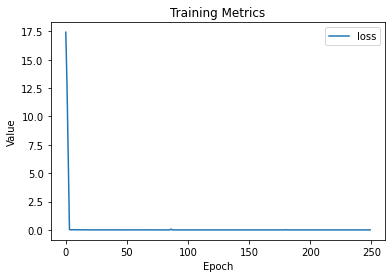

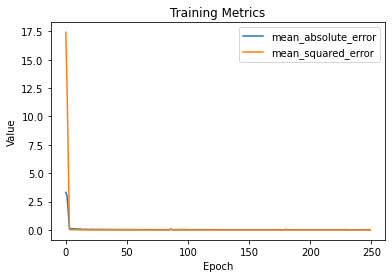

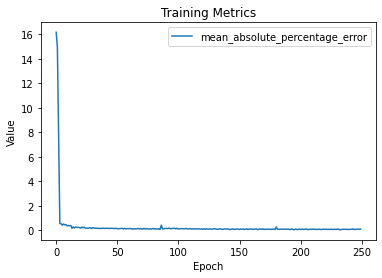

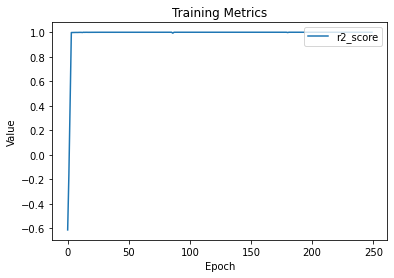

done
[200, 200, 250, 10] 0.5688369810674239


/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


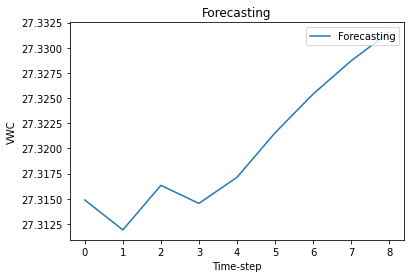

Duration: 0:41:17.079072
------------------------------------------------------------------------------------
['S2_Top_VWC_Avg' 'Rain']
Total configs: 1


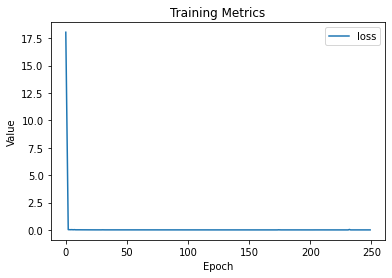

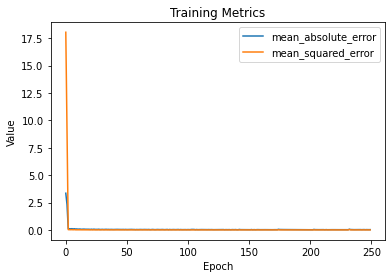

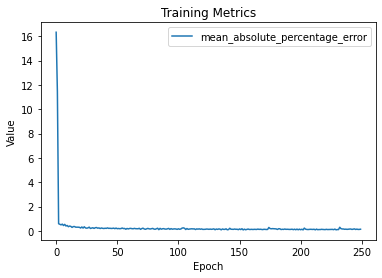

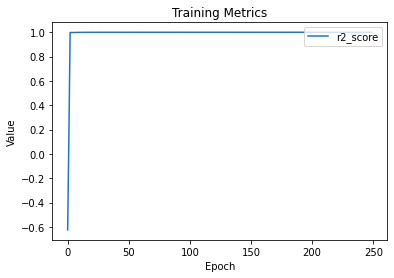

done
[200, 200, 250, 10] 0.6783301234219374


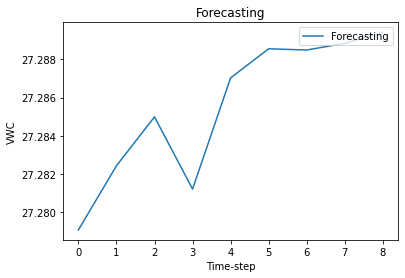

Duration: 0:43:32.958043
------------------------------------------------------------------------------------
+++++++++++++++++++++++++++++++++++++mmmmmmmmmmmmmm++++++++++++++++++++++++++++++++++++++


In [ ]:
#dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

Scores_IMF = []
for m in range(8, 9):

  sc = ([0, 0, 0, 0], 0, 0, 0, 0, 0)
  print('IMF: ', m)
  data = pd.DataFrame(IMFs[m]).T
  data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']
  testing = data[-8438:]
  data = data[:-8438] 

  %time
  External = data[['Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                 'Wind Speed', 'Wind Direction', 'Solar Radiation']]
  Predicted = data[['S2_Top_Temp_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S2_Top_Temp_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity', 'Dew Point', 
                  'Wind Speed', 'Wind Direction', 'Solar Radiation']

  for i in range(1,3):
      
      start_time = datetime.now()
      print(df.columns[0:i].values)
      df_s = df[df.columns[0:i].values]
      #split into train and test
      train, test = split_dataset(df_s.values)

      n_test = 12
      cfg_list= model_configs()
      verbose = False
      scores, predictions = grid_search(train, test, cfg_list, verbose)
      print('done')
      sc = np.vstack((sc, scores))
      for cfg, error, _, _, _, _ in scores[:10]:
        print(cfg, error)
      plt.clf()
      plt.plot(predictions[0][0])
      plt.title('Forecasting')
      plt.ylabel('VWC')
      plt.xlabel('Time-step')
      plt.legend(['Forecasting'], loc='upper right')
      plt.show()
      #plt.plot((trial[0][1])[41])
      end_time = datetime.now()

      print('Duration: {}'.format(end_time - start_time))
      print('------------------------------------------------------------------------------------')
  Scores_IMF = np.stack(sc)
  print('+++++++++++++++++++++++++++++++++++++mmmmmmmmmmmmmm++++++++++++++++++++++++++++++++++++++')
np.save('/content/drive/Shareddrives/1st Paper/Scores/S2.npy', Scores_IMF, allow_pickle=True) 